# Import Libraries

In [1]:
import pandas as pd
import re
import numpy as np
from numpy.random import seed
from tensorflow import set_random_seed
import random
from bs4 import BeautifulSoup
from yellowbrick.text import FreqDistVisualizer
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import itertools
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import os
from os import path
from wordcloud import WordCloud

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load the Data

In [3]:
satire = pd.read_csv('./Assets/Satire_final_articles.csv')
news = pd.read_csv('./Assets/Non_satire_final_articles.csv')

In [4]:
news.head()

,Unnamed: 0,index,date,source,text,title,url
0,0,0,2018-06-14 00:00:00,cnn.com,The best photos of the 2018 World Cup\n\nRungr...,The best photos of the 2018 World Cup,http://cnn.com/2018/06/14/football/gallery/wor...
1,1,1,2018-06-24 00:00:00,cnn.com,Jerusalem (CNN) The Duke of Cambridge faces pe...,Prince William's Mideast tour will be his toug...,http://cnn.com/2018/06/24/middleeast/prince-wi...
2,2,2,2018-06-15 00:00:00,cnn.com,"Melbourne, Australia (CNN) The murder of a 22-...",Eurydice Dixon: Tributes and anger as Australi...,http://cnn.com/2018/06/15/australia/australia-...
3,3,3,2018-06-22 00:00:00,cnn.com,(CNN) The Hungarian State Opera has canceled a...,Some 'Billy Elliot' shows canceled in Hungary ...,http://cnn.com/2018/06/22/europe/billy-elliot-...
4,4,4,2018-06-22 00:00:00,cnn.com,(CNN) He was touted as the savior of English r...,Eddie Jones: A coach under fire,http://cnn.com/2018/06/22/sport/eddie-jones-en...


In [5]:
satire.head()

,Unnamed: 0,index,date,text,title,url,source
0,0,0,NaN,"LA MALBAIE, CANADA (The Borowitz Report)—Sayin...","Macron, Trudeau Say They Weren’t Going to Tell...",https://www.newyorker.com/humor/borowitz-repor...,www.newyorker.com
1,1,1,NaN,WASHINGTON (The Borowitz Report)—The Philadelp...,Philadelphia Eagles Accept Mueller’s Offer to ...,https://www.newyorker.com/humor/borowitz-repor...,www.newyorker.com
2,2,2,NaN,WASHINGTON (The Borowitz Report)—As new detail...,Trump Agrees to Let Kim Jong Un Have Pence as ...,https://www.newyorker.com/humor/borowitz-repor...,www.newyorker.com
3,3,3,NaN,WASHINGTON (The Borowitz Report)—Shortly after...,Foreigners Unsure Why Anyone Would Want to Tra...,https://www.newyorker.com/humor/borowitz-repor...,www.newyorker.com
4,4,4,NaN,WASHINGTON (The Borowitz Report)—The White Hou...,White House in Panic Mode After TV Star with R...,https://www.newyorker.com/humor/borowitz-repor...,www.newyorker.com


In [7]:
# Dropping accidental additional indices

satire.drop(labels=['Unnamed: 0', 'index'], axis=1, inplace=True)
satire.reset_index(inplace=True)

news.drop(labels=['Unnamed: 0', 'index'], axis=1, inplace=True)
news.reset_index(inplace=True)

In [8]:
news.tail()

,index,date,source,text,title,url
820,820,2018-07-04 00:00:00,www.bbc.com,"After a long, uphill cycle to the Danish battl...",The curious story of Denmark’s rebel cakes,http://www.bbc.com/travel/story/20180704-the-c...
821,821,NaN,www.bbc.co.uk,"For many teens, purchasing your first copy of ...",7 of the weirdest tracks on 100 editions of No...,http://www.bbc.co.uk/programmes/articles/b1c7f...
822,822,NaN,www.bbc.co.uk,"When Rembrandt van Rijn died, aged 63, lonely,...",Rediscovering Rembrandt: How the British rescu...,http://www.bbc.co.uk/programmes/articles/4m0Dg...
823,823,NaN,www.bbc.co.uk,"Find out about how our fixers work, how they g...",Want to think like a Fixer?,http://www.bbc.co.uk/programmes/articles/pCmkp...
824,824,NaN,www.bbc.co.uk,GLOW is the critically-acclaimed Netflix serie...,Seven times the art world grappled with wrestling,http://www.bbc.co.uk/programmes/articles/220yc...


In [9]:
satire.tail()

,index,date,text,title,url,source
722,722,2018-07-04 10:14:28+01:00,MOSCOW - Russia - The England team cleared out...,Have England Signed Death Sentence For Colombi...,https://www.dailysquib.co.uk/sports/29022-have...,www.dailysquib.co.uk
723,723,2018-05-22 12:25:50+01:00,LONDON - England - The biological part of huma...,Experts: Big Technological Shift Coming Soon,https://www.dailysquib.co.uk/sci_tech/28665-ex...,www.dailysquib.co.uk
724,724,2018-05-31 13:04:24+01:00,"All it takes is a few words, a few well chosen...",Cultural Marxism,https://www.dailysquib.co.uk/world/28757-cultu...,www.dailysquib.co.uk
725,725,2011-11-17 09:10:00+01:00,LONDON - England - After the spate of thefts a...,New Plastic War Memorials For War Heroes,https://www.dailysquib.co.uk/world/3065-new-pl...,www.dailysquib.co.uk
726,726,2017-07-03 12:11:59+01:00,WASHINGTON D.C. - USA - Melania Trump has reve...,Melania: When Donald Farts He is Always a Gent...,https://www.dailysquib.co.uk/world/25641-melan...,www.dailysquib.co.uk


# EDA

**Getting Source for Papers**

In [10]:
# Use Regex token to get domain of paper source

satire['source'] = satire['url'].str.extract(r'\/\/(.[^/]+)/')
news['source'] = news['url'].str.extract(r'\/\/(.[^/]+)/')

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [11]:
all_articles = [satire, news]

**Dropping duplicates**

In [12]:
# Replacing instances of https: with http:

def https_cleaner(row):
    url = 'https:'
    return row.replace(url, 'http:')

In [13]:
for i in all_articles:
    i['url'] = i['url'].map(https_cleaner)
    i.drop_duplicates(subset='url', keep='first', inplace=True)
    print(i.shape)

(660, 6)
(825, 6)


In [14]:
for i in all_articles:
    print(i['source'].value_counts())
    print()

www.clickhole.com             104
www.thedailymash.co.uk         90
www.dailysquib.co.uk           72
waterfordwhispersnews.com      63
www.thebeaverton.com           58
makeamericathebest.com         54
politics.theonion.com          26
local.theonion.com             26
theskunk.org                   26
thevalleyreport.com            25
entertainment.theonion.com     24
sports.theonion.com            23
www.theonion.com               21
islamicanews.com               20
babylonbee.com                 18
www.newyorker.com              10
Name: source, dtype: int64

cnn.com            325
www.nytimes.com    181
nbcnews.com        136
www.bbc.com         75
www.foxnews.com     68
www.nbcnews.com     36
www.bbc.co.uk        4
Name: source, dtype: int64



**Removing any accidental imports with less than 10 articles**

In [15]:
# This was initially done before specifying subdomains, 
# so it's commented out to avoid losing the additional links

# for i in all_articles:
#     counts = i['source'].value_counts()
#     i = i[i.isin(counts.index[counts > 10]).values]

**Cleaning up irrelevant and out-dated articles**

In [16]:
# Identifying what kind of URLs are included in each domain
# Using this to clean up links that may include video, for example

satire[satire['url'].str.contains("clickhole.com")]

,index,date,text,title,url,source
10,10,NaN,These games would have been incredible if not ...,5 Classic Video Games That Are Sadly Ruined Be...,http://www.clickhole.com/5-classic-video-games...,www.clickhole.com
11,11,NaN,Heartbreaking: This Man Starved To Death Becau...,Roll Call! Comment “Present” Below To Verify T...,http://www.clickhole.com/roll-call-comment-pre...,www.clickhole.com
12,12,NaN,Ever wonder what’s on the mind of today’s most...,"Find Out What Blake Lively, Ruth Bader Ginsbur...",http://www.clickhole.com/find-out-what-blake-l...,www.clickhole.com
13,13,NaN,Here’s some major health news that is totally ...,Major Breakthrough: Medical Researchers Just A...,http://www.clickhole.com/major-breakthrough-me...,www.clickhole.com
14,14,NaN,Ever wonder what’s on the mind of today’s most...,"Find Out What Warren Buffett, Reese Witherspoo...",http://www.clickhole.com/find-out-what-warren-...,www.clickhole.com
15,15,NaN,AT&T just had a full-blown social media meltdo...,Fed Up: AT&T Has Announced That If You Think Y...,http://www.clickhole.com/fed-up-at-t-has-annou...,www.clickhole.com
16,16,NaN,SeaWorld has faced a ton of backlash over the ...,One For The Road: SeaWorld Has Realized People...,http://www.clickhole.com/one-for-the-road-seaw...,www.clickhole.com
17,17,NaN,Ever wonder what’s on the mind of today’s most...,"Find Out What Neil deGrasse Tyson, Demi Lovato...",http://www.clickhole.com/find-out-what-neil-de...,www.clickhole.com
18,18,NaN,"Buckle up, Harry Potter fans, because J.K. Row...",Big Step Backward: J.K. Rowling Has Revealed T...,http://www.clickhole.com/big-step-backward-j-k...,www.clickhole.com
19,19,NaN,With the group phase finished and the knockout...,A Referee Has Not Won The Tournament Since 197...,http://www.clickhole.com/a-referee-has-not-won...,www.clickhole.com


In [17]:
clickhole = satire[satire['url'].str.contains("www.clickhole.com",
                                              "news.clickhole.com")].copy()
borowitz = satire[satire['url'].str.contains("www.newyorker.com/humor/borowitz")].copy()
onion = satire[satire['url'].str.contains("theonion.com")].copy()
skunk = satire[satire['url'].str.contains("theskunk.org")].copy()
islamica = satire[satire['url'].str.contains("islamicanews.com")].copy()
matb = satire[satire['url'].str.contains("makeamericathebest.com")].copy()

# Amazingly enough, cannot work with more than two strings at once

beaverton = satire[satire['url'].str.contains("thebeaverton.com/news/",
                                              "thebeaverton.com/2018")].copy()
beaverton_older = satire[satire['url'].str.contains("thebeaverton.com/2017")].copy()
wwn = satire[satire['url'].str.contains("waterfordwhispersnews.com")].copy()
dailymash = satire[satire['url'].str.contains("thedailymash.co.uk")].copy()
dailysquib = satire[satire['url'].str.contains("dailysquib.co.uk")].copy()
valley = satire[satire['url'].str.contains("thevalleyreport.com")].copy()
babylon = satire[satire['url'].str.contains("babylonbee.com")].copy()

In [18]:
final_satire = [borowitz, clickhole, onion, skunk, islamica, matb, valley, babylon, # American
                beaverton, beaverton_older, wwn, dailymash, dailysquib] # Canadian, British, Irish

satire = pd.concat(final_satire)
satire.to_csv(path_or_buf='Satire_final_articles_7-12.csv')

satire.tail()

,index,date,text,title,url,source
722,722,2018-07-04 10:14:28+01:00,MOSCOW - Russia - The England team cleared out...,Have England Signed Death Sentence For Colombi...,http://www.dailysquib.co.uk/sports/29022-have-...,www.dailysquib.co.uk
723,723,2018-05-22 12:25:50+01:00,LONDON - England - The biological part of huma...,Experts: Big Technological Shift Coming Soon,http://www.dailysquib.co.uk/sci_tech/28665-exp...,www.dailysquib.co.uk
724,724,2018-05-31 13:04:24+01:00,"All it takes is a few words, a few well chosen...",Cultural Marxism,http://www.dailysquib.co.uk/world/28757-cultur...,www.dailysquib.co.uk
725,725,2011-11-17 09:10:00+01:00,LONDON - England - After the spate of thefts a...,New Plastic War Memorials For War Heroes,http://www.dailysquib.co.uk/world/3065-new-pla...,www.dailysquib.co.uk
726,726,2017-07-03 12:11:59+01:00,WASHINGTON D.C. - USA - Melania Trump has reve...,Melania: When Donald Farts He is Always a Gent...,http://www.dailysquib.co.uk/world/25641-melani...,www.dailysquib.co.uk


In [19]:
cnn = news[news['url'].str.contains("http://cnn.com/2018/")].copy()
nbc_main = news[news['url'].str.contains("nbcnews.com/news/",
                                         "nbcnews.com/storyline/")].copy()
nbc_health_biz = news[news['url'].str.contains("nbcnews.com/health",
                                               "nbcnews.com/business/")].copy()
fox_main = news[news['url'].str.contains("foxnews.com/us",
                                         "foxnews.com/2018")].copy()
fox_sci = news[news['url'].str.contains("foxnews.com/health",
                                        "foxnews.com/science")].copy()
fox_world_polit = news[news['url'].str.contains("foxnews.com/world",
                                                "foxnews.com/politics")].copy()
fox_tech_sports = news[news['url'].str.contains("foxnews.com/tech", 
                                                "foxnews.com/sports")].copy()
bbc_main = news[news['url'].str.contains("bbc.com/news/",
                                         "bbc.co.uk/news/")].copy()
bbc_com = news[news['url'].str.contains("bbc.com/travel/",
                                        "bbc.com/future/")].copy()
bbc_couk = news[news['url'].str.contains("bbc.co.uk/programmes/",
                                         "bbc.co.uk/music/")].copy()
nyt = news[news['url'].str.contains("www.nytimes.com")].copy()

In [20]:
final_news = [cnn, nbc_main, nbc_health_biz, fox_main, fox_sci, fox_world_polit, fox_tech_sports, nyt, # American
              bbc_main, bbc_com, bbc_couk] # British

news = pd.concat(final_news)
news.to_csv(path_or_buf='Non_satire_final_articles_7-12.csv')

news.head()

,index,date,source,text,title,url
0,0,2018-06-14 00:00:00,cnn.com,The best photos of the 2018 World Cup\n\nRungr...,The best photos of the 2018 World Cup,http://cnn.com/2018/06/14/football/gallery/wor...
1,1,2018-06-24 00:00:00,cnn.com,Jerusalem (CNN) The Duke of Cambridge faces pe...,Prince William's Mideast tour will be his toug...,http://cnn.com/2018/06/24/middleeast/prince-wi...
2,2,2018-06-15 00:00:00,cnn.com,"Melbourne, Australia (CNN) The murder of a 22-...",Eurydice Dixon: Tributes and anger as Australi...,http://cnn.com/2018/06/15/australia/australia-...
3,3,2018-06-22 00:00:00,cnn.com,(CNN) The Hungarian State Opera has canceled a...,Some 'Billy Elliot' shows canceled in Hungary ...,http://cnn.com/2018/06/22/europe/billy-elliot-...
4,4,2018-06-22 00:00:00,cnn.com,(CNN) He was touted as the savior of English r...,Eddie Jones: A coach under fire,http://cnn.com/2018/06/22/sport/eddie-jones-en...


**Correcting source names**

In [21]:
satire['source'].unique()

array(['www.newyorker.com', 'www.clickhole.com', 'local.theonion.com',
       'sports.theonion.com', 'www.theonion.com', 'politics.theonion.com',
       'entertainment.theonion.com', 'theskunk.org', 'islamicanews.com',
       'makeamericathebest.com', 'thevalleyreport.com', 'babylonbee.com',
       'www.thebeaverton.com', 'waterfordwhispersnews.com',
       'www.thedailymash.co.uk', 'www.dailysquib.co.uk'], dtype=object)

In [22]:
def updating_satire_sources(x):
    borowitz = ['www.newyorker.com']
    clickhole = ['www.clickhole.com']
    onion = ['local.theonion.com', 'sports.theonion.com', 'www.theonion.com', 'politics.theonion.com',
             'entertainment.theonion.com']
    skunk = ['theskunk.org']
    islamica = ['islamicanews.com']
    matb = ['makeamericathebest.com']
    valley = ['thevalleyreport.com']
    babylon = ['babylonbee.com']
    beaverton = ['www.thebeaverton.com']
    wwn = ['waterfordwhispersnews.com']
    dailymash = ['www.thedailymash.co.uk']
    dailysquib = ['www.dailysquib.co.uk']
    
    if x in borowitz:
        return 'Borowitz Report'
    elif x in clickhole:
        return 'Clickhole'
    elif x in onion:
        return 'The Onion'
    elif x in skunk:
        return 'The Skunk'
    elif x in islamica:
        return 'Islamica News'
    elif x in matb:
        return 'Make America the Best'
    elif x in valley:
        return 'Valley Report'
    elif x in babylon:
        return 'Babylon Bee'
    elif x in beaverton:
        return 'The Beaverton'
    elif x in wwn:
        return 'Waterford Whispers News'
    elif x in dailymash:
        return 'The Daily Mash'
    elif x in dailysquib:
        return 'The Daily Squib'
    else:
        return 0

In [23]:
satire['updated_source'] = satire['source'].map(updating_satire_sources)

satire['source'].value_counts()

www.clickhole.com             104
www.thedailymash.co.uk         90
www.dailysquib.co.uk           72
waterfordwhispersnews.com      63
www.thebeaverton.com           58
makeamericathebest.com         54
politics.theonion.com          26
local.theonion.com             26
theskunk.org                   26
thevalleyreport.com            25
entertainment.theonion.com     24
sports.theonion.com            23
www.theonion.com               21
islamicanews.com               20
babylonbee.com                 18
www.newyorker.com              10
Name: source, dtype: int64

In [24]:
news['source'].unique()

array(['cnn.com', 'nbcnews.com', 'www.nbcnews.com', 'www.foxnews.com',
       'www.nytimes.com', 'www.bbc.com', 'www.bbc.co.uk'], dtype=object)

In [25]:
def updating_news_sources(x):
    cnn = ['cnn.com']
    nbc = ['nbcnews.com', 'www.nbcnews.com']
    fox = ['www.foxnews.com']
    nyt = ['www.nytimes.com']
    bbc = ['www.bbc.com', 'www.bbc.co.uk']
    
    if x in cnn:
        return 'CNN'
    elif x in nbc:
        return 'NBC News'
    elif x in fox:
        return 'FOX News'
    elif x in nyt:
        return 'The New York Times'
    elif x in bbc:
        return 'The BBC'
    else:
        return 0

In [26]:
news['updated_source'] = news['source'].map(updating_news_sources)

news['source'].value_counts()

cnn.com            325
www.nytimes.com    181
nbcnews.com        136
www.bbc.com         75
www.foxnews.com     68
www.nbcnews.com     36
www.bbc.co.uk        4
Name: source, dtype: int64

**Removing HTML from scraping**

In [27]:
def text_cleaner(df):
    cleaned_text = []
    for i in df['text']:
        x = BeautifulSoup(i, 'lxml')
        cleaned_text.append(x.get_text())
    df['cleaned_text'] = cleaned_text

In [28]:
text_cleaner(news)

In [29]:
# Can't run text cleaner on null rows

satire.isnull().sum()

index               0
date              341
text                2
title               0
url                 0
source              0
updated_source      0
dtype: int64

In [30]:
satire.dropna(axis=0, how='any', subset=['text'], inplace=True)

In [31]:
text_cleaner(satire)

**Setting Labels**

In [32]:
satire['label'] = 1
news['label'] = 0

**Combining DFs**

In [33]:
articles = [satire, news]
all_articles = pd.concat(articles)

**Cleaning Text**

In [34]:
all_articles['updated_source'].unique()

array(['Borowitz Report', 'Clickhole', 'The Onion', 'The Skunk',
       'Islamica News', 'Make America the Best', 'Valley Report',
       'Babylon Bee', 'The Beaverton', 'Waterford Whispers News',
       'The Daily Mash', 'The Daily Squib', 'CNN', 'NBC News', 'FOX News',
       'The New York Times', 'The BBC'], dtype=object)

In [35]:
# Removing instances of paper name/abbreviation in self-reference

def title_words_eraser(row):
    title_words = ['The Borowitz Report', 'Clickhole', 'Click Hole', 'The Onion', 'TheSkunk.org', 'Islamica News', 
                   'Make America the Best', 'Valley Report', 'Babylon Bee', 'The Beaverton', 
                   'Waterford Whispers News', 'WWN', 'wwn', 'The Daily Mash', 'The Daily Squib', 'The Squib',
                   'CNN', 'cnn', 'NBC', 'MSNBC', 'FOX', 'New York Times']
    
    for x in title_words:
        row = row.replace(x, '')
    return row

In [36]:
# Remove non-article text picked up during scraping (found in word frequencies and clouds)

def boilerplate_cleaner(row):
    text = ['Continue reading the main story', 'Share 0 SHARES', 'Advertisement', 'Image copyright', 
            "Newsletter Sign Up Continue reading the main story Please verify you're not a robot by clicking \
            the box. Invalid email address. Please re-enter. You must select a newsletter to subscribe to. Sign \
            Up You will receive emails containing news content , updates and promotions from The New York Times. \
            You may opt-out at any time. You agree to receive occasional updates and special offers for The New \
            York Times's products and services. Thank you for subscribing. An error has occurred. Please try \
            again later. View all New York Times newsletters."]
    
    for x in text:
        row = row.replace(x, '')
    return row

In [37]:
# Remove /n instances

def break_cleaner(row):
    breaker = '\n'
    return row.replace(breaker, ' ')

# Remove double spaces

def double_space_cleaner(row):
    spaces = '  '
    return row.replace(spaces, ' ')

In [38]:
all_articles['no_paper'] = all_articles['cleaned_text'].map(title_words_eraser)
all_articles['no_paper_breaks'] = all_articles['no_paper'].map(break_cleaner)
all_articles['clean_boilerplate'] = all_articles['no_paper_breaks'].map(boilerplate_cleaner)
all_articles['final_clean_text'] = all_articles['clean_boilerplate'].map(double_space_cleaner)

**Establishing Word Count Limit**

In [39]:
all_articles['word_count'] = all_articles['final_clean_text'].map(lambda x: len(x.split()))

In [40]:
all_articles['word_count'].describe()

count    1483.000000
mean      403.807822
std       440.637204
min         3.000000
25%       158.000000
50%       267.000000
75%       503.000000
max      4705.000000
Name: word_count, dtype: float64

In [41]:
# Determining how many articles above 650 words

print(all_articles[all_articles['word_count'] > 650].shape)

# Which kind of articles above 1,000 words

all_articles[all_articles['word_count'] > 1000]

(280, 14)


,cleaned_text,date,index,label,source,text,title,updated_source,url,no_paper,no_paper_breaks,clean_boilerplate,final_clean_text,word_count
55,"O, comrades, gather ’round! Let me tell you of...",NaN,55,1,www.clickhole.com,"O, comrades, gather ’round! Let me tell you of...",All Of The Glorious R-Rated Movies I Have Seen...,Clickhole,http://www.clickhole.com/all-of-the-glorious-r...,"O, comrades, gather ’round! Let me tell you of...","O, comrades, gather ’round! Let me tell you of...","O, comrades, gather ’round! Let me tell you of...","O, comrades, gather ’round! Let me tell you of...",1064
692,When we think about the world of online gambli...,2018-05-16 09:26:32+01:00,692,1,www.dailysquib.co.uk,When we think about the world of online gambli...,UKGC is Fighting Gambling Operators with Big F...,The Daily Squib,http://www.dailysquib.co.uk/business/28761-ukg...,When we think about the world of online gambli...,When we think about the world of online gambli...,When we think about the world of online gambli...,When we think about the world of online gambli...,1008
13,(CNN) It was in the thick of the Arab Spring i...,2018-06-19 00:00:00,13,0,cnn.com,(CNN) It was in the thick of the Arab Spring i...,Saudi driving ban: The women who campaigned to...,CNN,http://cnn.com/2018/06/19/middleeast/saudi-wom...,() It was in the thick of the Arab Spring in 2...,() It was in the thick of the Arab Spring in 2...,() It was in the thick of the Arab Spring in 2...,() It was in the thick of the Arab Spring in 2...,1323
15,This essay is part of a column called The Wisd...,2018-01-05 00:00:00,15,0,cnn.com,This essay is part of a column called The Wisd...,"Start a new (good) habit, kill an old (bad) one",CNN,http://cnn.com/2018/01/05/health/habits-wisdom...,This essay is part of a column called The Wisd...,This essay is part of a column called The Wisd...,This essay is part of a column called The Wisd...,This essay is part of a column called The Wisd...,1969
16,San Diego (CNN) Not many of us can run a marat...,2018-06-21 00:00:00,16,0,cnn.com,San Diego (CNN) Not many of us can run a marat...,His son's battle with cancer inspired his epic...,CNN,http://cnn.com/2018/06/21/health/cnnheroes-ric...,San Diego () Not many of us can run a marathon...,San Diego () Not many of us can run a marathon...,San Diego () Not many of us can run a marathon...,San Diego () Not many of us can run a marathon...,1038
20,(CNN) Maybe there's no need for a fountain of ...,2018-03-22 00:00:00,20,0,cnn.com,(CNN) Maybe there's no need for a fountain of ...,Cut your calories by 15% to stay young,CNN,http://cnn.com/2018/03/22/health/calorie-restr...,() Maybe there's no need for a fountain of you...,() Maybe there's no need for a fountain of you...,() Maybe there's no need for a fountain of you...,() Maybe there's no need for a fountain of you...,1095
21,"(CNN) It could happen at any time: Eventually,...",2018-06-22 00:00:00,21,0,cnn.com,"(CNN) It could happen at any time: Eventually,...",Social media and kids: What age do they start?,CNN,http://cnn.com/2018/06/22/health/social-media-...,"() It could happen at any time: Eventually, yo...","() It could happen at any time: Eventually, yo...","() It could happen at any time: Eventually, yo...","() It could happen at any time: Eventually, yo...",1128
23,Photos: Wonders of the universe The UAE plans ...,2018-06-20 00:00:00,23,0,cnn.com,Photos: Wonders of the universe The UAE plans ...,First UAE astronaut heading to International S...,CNN,http://cnn.com/2018/06/20/middleeast/uae-first...,Photos: Wonders of the universe The UAE plans ...,Photos: Wonders of the universe The UAE plans ...,Photos: Wonders of the universe The UAE plans ...,Photos: Wonders of the universe The UAE plans ...,3208
28,"Brooklyn, NY (CNN) As an emergency physician a...",2018-04-26 00:00:00,28,0,cnn.com,"Brooklyn, NY (CNN) As an emergency physician a...",Doctor works to save youth from violence befor...,CNN,http://cnn.com/2018/04/26/health/cnnheroes-rob...,"Brooklyn, NY 

In [42]:
# Setting word count limit to 650 first words since most 1,000+ word articles are news

all_articles['truncated_text'] = all_articles['final_clean_text'].map(lambda x: ' '.join(x.split(' ')[:651]))
all_articles['new_word_count'] = all_articles['truncated_text'].map(lambda x: len(x.split()))

In [43]:
# Saving work!

all_articles.to_csv(path_or_buf='./Assets/ALL_articles_7-12.csv')

**CountVectorizer**

In [44]:
all_articles = pd.read_csv('./Assets/ALL_articles_7-12.csv')

all_articles['label'].value_counts()

0    825
1    658
Name: label, dtype: int64

In [3]:
# Creating masks

satire_class = all_articles.loc[all_articles['label'] == 1]
news_class = all_articles.loc[all_articles['label'] == 0]

In [97]:
# Count Vectorizer without stopwords, using monograms

cvec = CountVectorizer(stop_words=None, max_features=50)

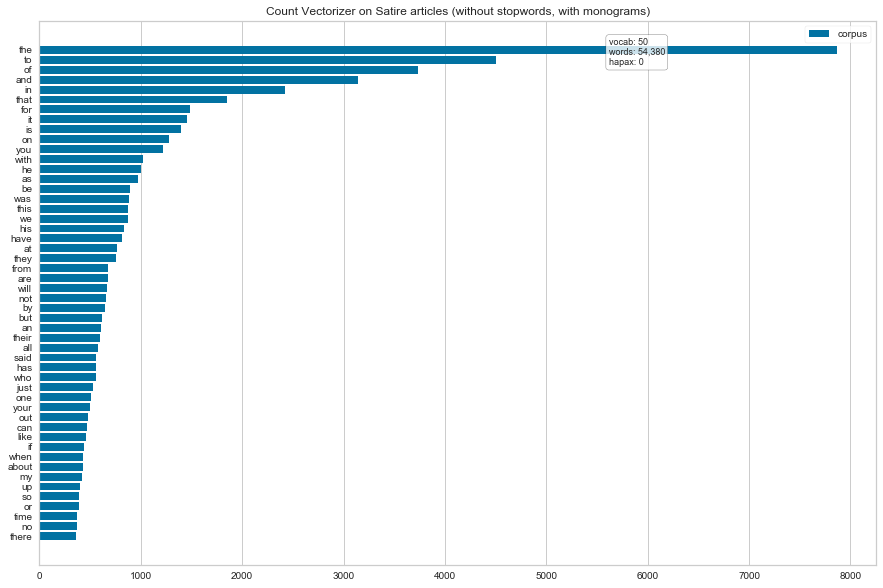

In [100]:
satire_text = cvec.fit_transform(satire_class['truncated_text'])
top_50_satire = cvec.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire, 
                          title='Count Vectorizer on Satire articles (without stopwords, with monograms)')
plot.fit(satire_text)
plot.poof()

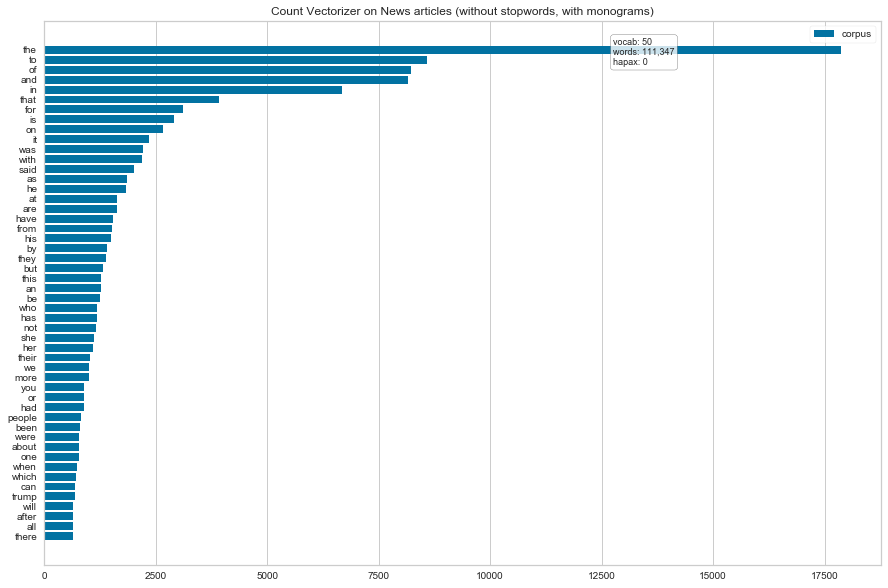

In [99]:
news_text = cvec.fit_transform(news_class['truncated_text'])
top_50_news = cvec.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news, 
                          title='Count Vectorizer on News articles (without stopwords, with monograms)')
plot.fit(news_text)
plot.poof()

In [102]:
# Count Vectorizer with stopwords, using monograms

cvec_stops = CountVectorizer(stop_words='english', max_features=50)

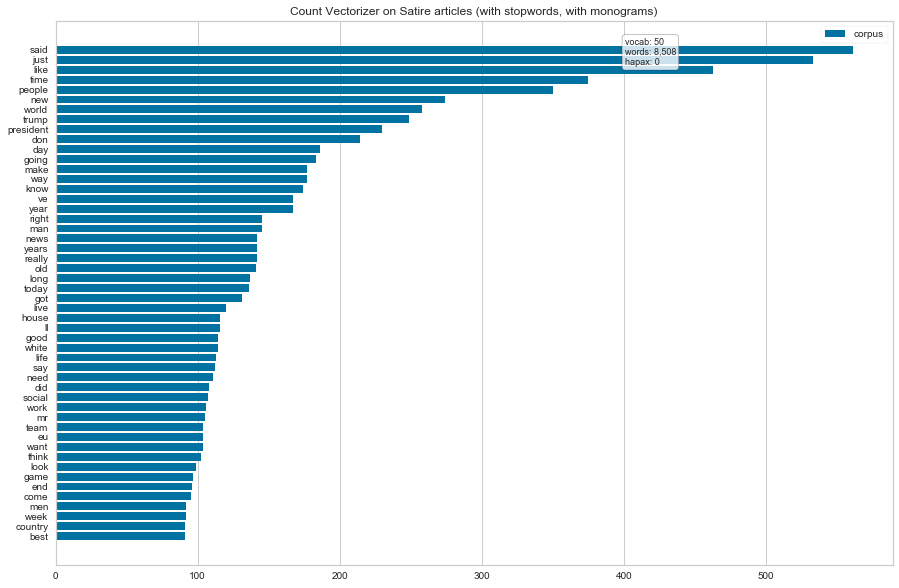

In [103]:
satire_text_stops = cvec_stops.fit_transform(satire_class['truncated_text'])
top_50_satire_stops = cvec_stops.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire_stops, 
                          title='Count Vectorizer on Satire articles (with stopwords, with monograms)')
plot.fit(satire_text_stops)
plot.poof()

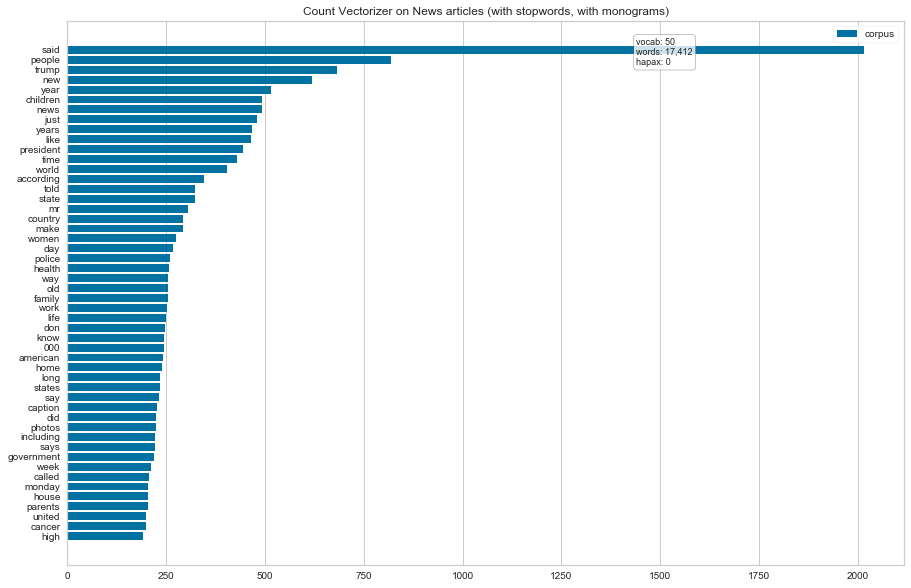

In [104]:
news_text_stops = cvec_stops.fit_transform(news_class['truncated_text'])
top_50_news_stops = cvec_stops.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news_stops, 
                          title='Count Vectorizer on News articles (with stopwords, with monograms)')
plot.fit(news_text_stops)
plot.poof()

In [105]:
# Count Vectorizer without stopwords, using binograms

cvec_bigrams = CountVectorizer(stop_words=None, max_features=50, ngram_range=(1, 2))

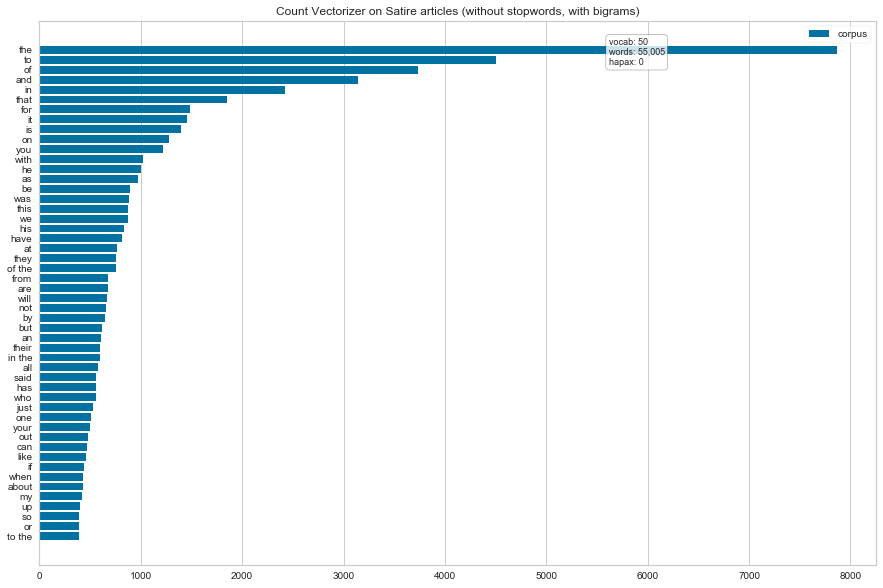

In [106]:
satire_text_ngram2 = cvec_bigrams.fit_transform(satire_class['truncated_text'])
top_50_satire_ngram2 = cvec_bigrams.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire_ngram2, 
                          title='Count Vectorizer on Satire articles (without stopwords, with bigrams)')
plot.fit(satire_text_ngram2)
plot.poof()

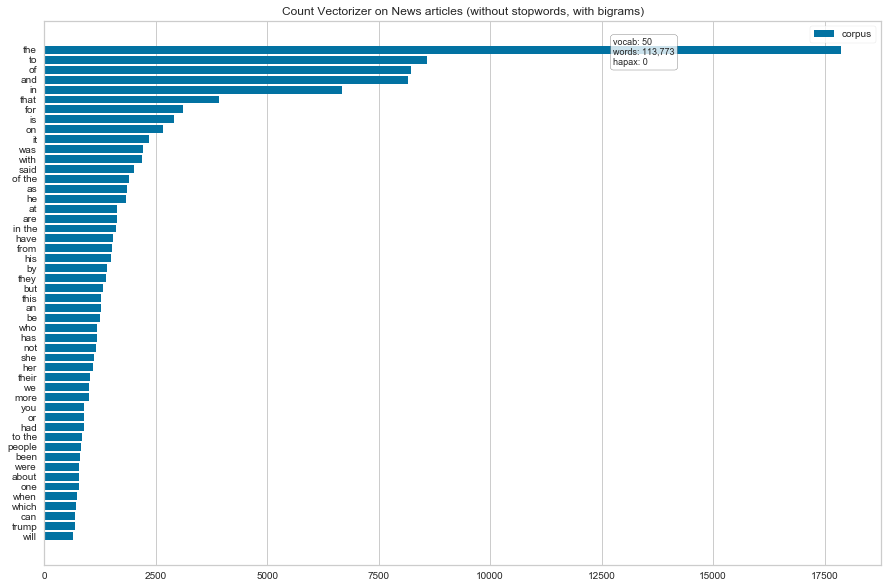

In [108]:
news_text_ngram2 = cvec_bigrams.fit_transform(news_class['truncated_text'])
top_50_news_ngram2 = cvec_bigrams.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news_ngram2, 
                          title='Count Vectorizer on News articles (without stopwords, with bigrams)')
plot.fit(news_text_ngram2)
plot.poof()

In [109]:
# Count Vectorizer with stopwords, using binograms

cvec_bigrams_stops = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))

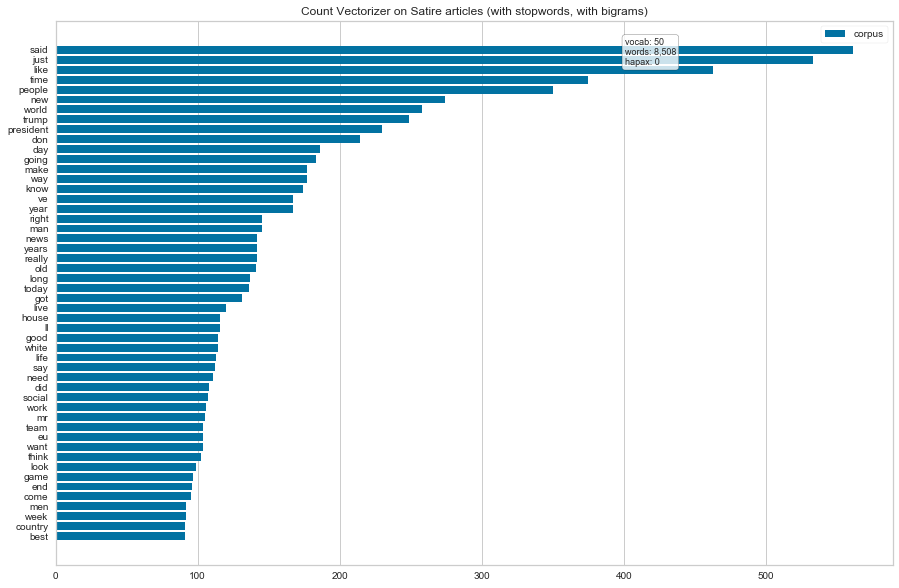

In [110]:
satire_text_ngram2_stops = cvec_bigrams_stops.fit_transform(satire_class['truncated_text'])
top_50_satire_ngram2_stops = cvec_bigrams_stops.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire_ngram2_stops, 
                          title='Count Vectorizer on Satire articles (with stopwords, with bigrams)')
plot.fit(satire_text_ngram2_stops)
plot.poof()

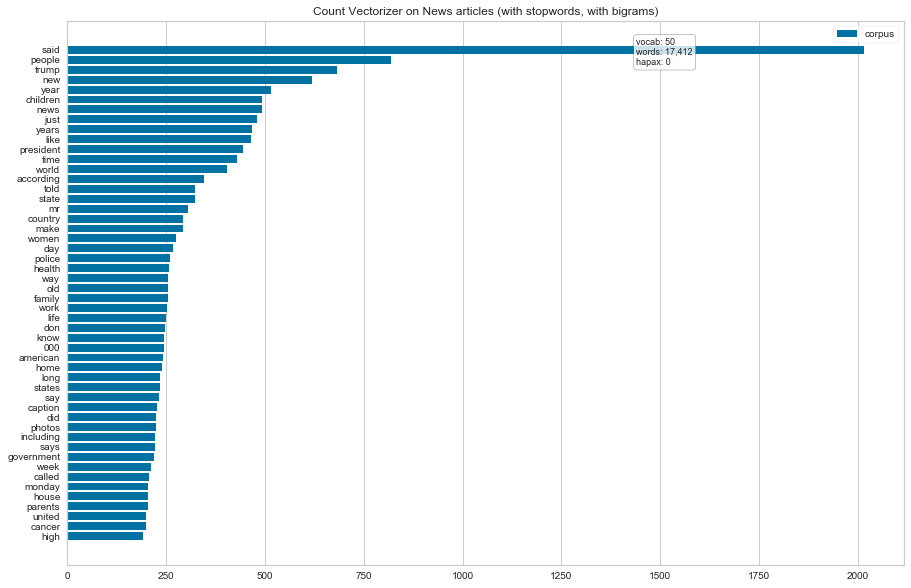

In [111]:
news_text_ngram2_stops = cvec_bigrams_stops.fit_transform(news_class['truncated_text'])
top_50_news_ngram2_stops = cvec_bigrams_stops.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news_ngram2_stops, 
                          title='Count Vectorizer on News articles (with stopwords, with bigrams)')
plot.fit(news_text_ngram2_stops)
plot.poof()

**TF-IDF Vectorizer**

In [112]:
# TF-IDF Vectorizer without stopwords, using monograms

tvec = TfidfVectorizer(stop_words=None, max_features=50)

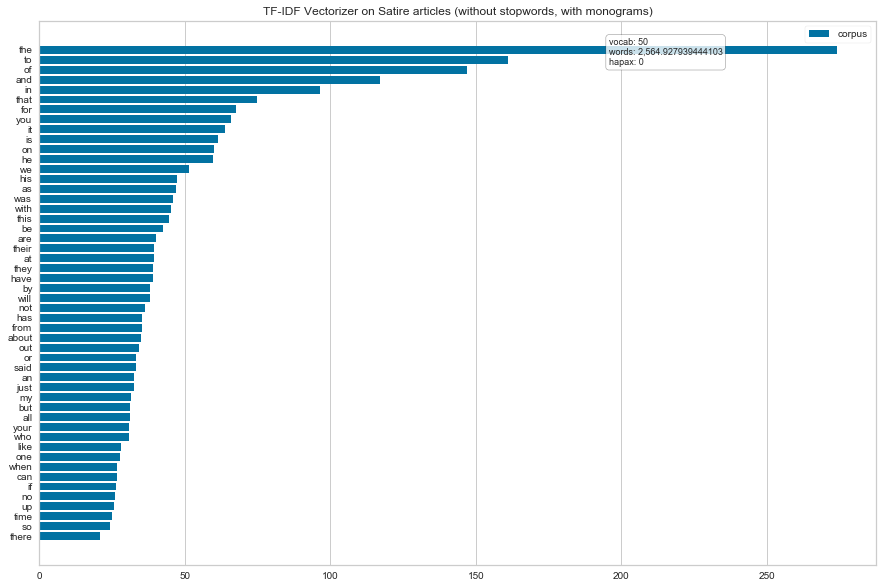

In [113]:
satire_text_tvec = tvec.fit_transform(satire_class['truncated_text'])
top_50_satire_tvec = tvec.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire_tvec, 
                          title='TF-IDF Vectorizer on Satire articles (without stopwords, with monograms)')
plot.fit(satire_text_tvec)
plot.poof()

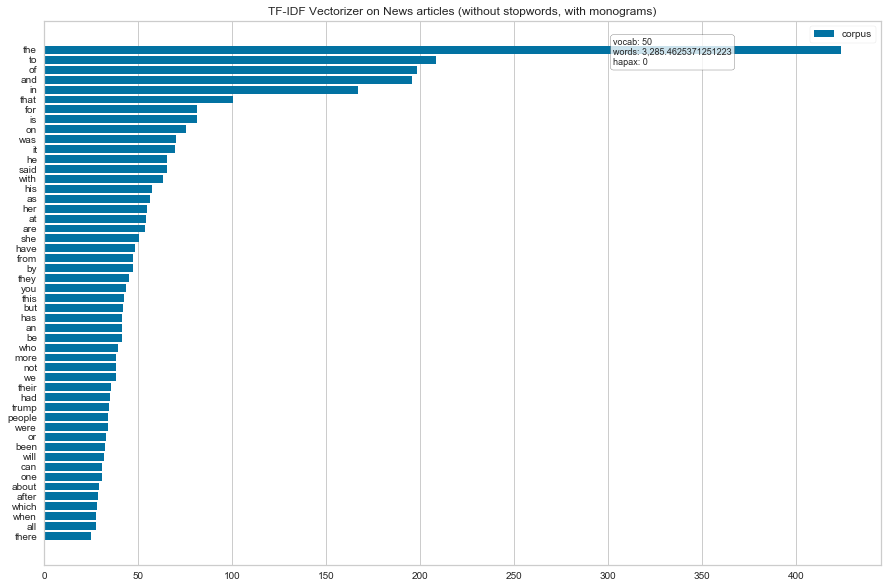

In [114]:
news_text_tvec = tvec.fit_transform(news_class['truncated_text'])
top_50_news_tvec = tvec.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news_tvec, 
                          title='TF-IDF Vectorizer on News articles (without stopwords, with monograms)')
plot.fit(news_text_tvec)
plot.poof()

In [115]:
# TF-IDF Vectorizer with stopwords, using monograms

tvec_stops = TfidfVectorizer(stop_words='english', max_features=50)

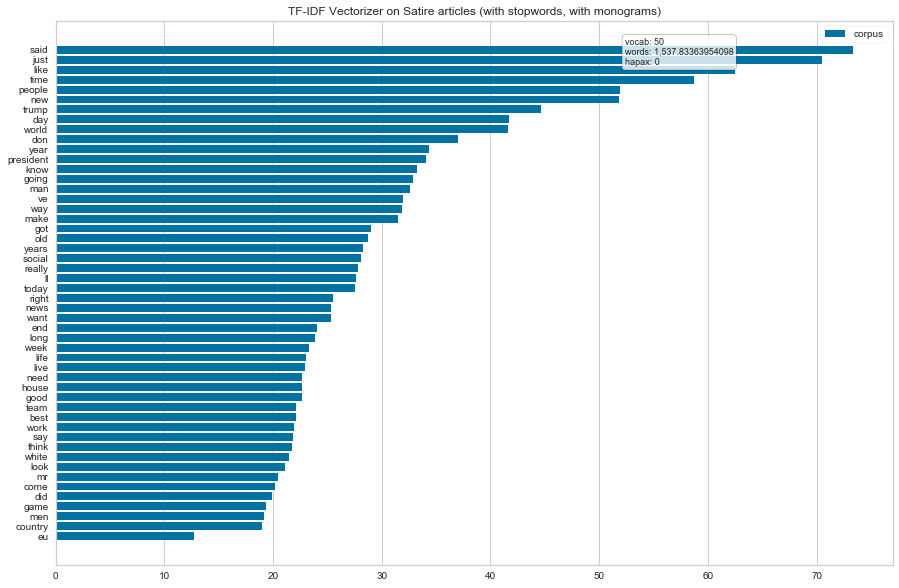

In [116]:
satire_text_tvec_stops = tvec_stops.fit_transform(satire_class['truncated_text'])
top_50_satire_tvec_stops = tvec_stops.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire_tvec_stops, 
                          title='TF-IDF Vectorizer on Satire articles (with stopwords, with monograms)')
plot.fit(satire_text_tvec_stops)
plot.poof()

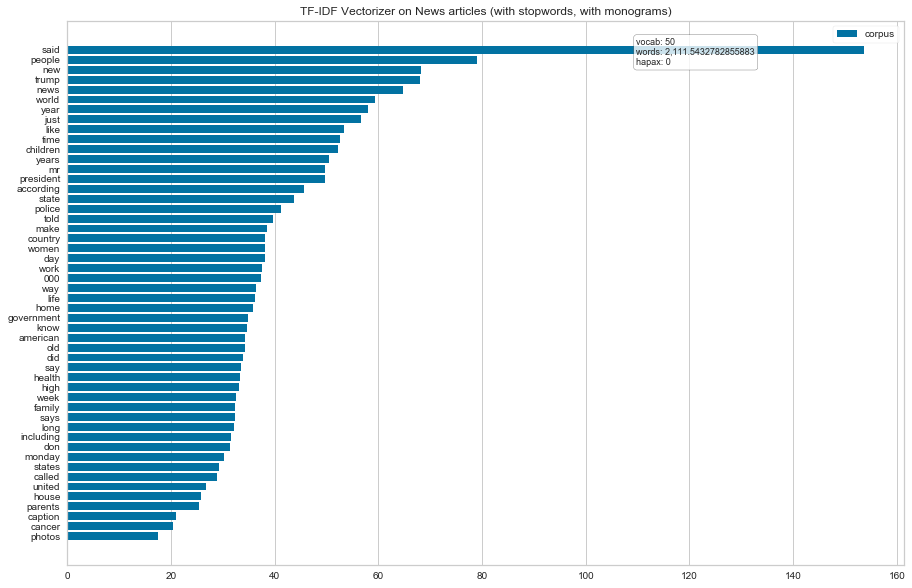

In [117]:
news_text_tvec_stops = tvec_stops.fit_transform(news_class['truncated_text'])
top_50_news_tvec_stops = tvec_stops.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news_tvec_stops, 
                          title='TF-IDF Vectorizer on News articles (with stopwords, with monograms)')
plot.fit(news_text_tvec_stops)
plot.poof()

In [118]:
# TF-IDF Vectorizer with stopwords, using bigrams (1,2)

tvec_stops_bigrams = TfidfVectorizer(stop_words='english', max_features=50, ngram_range=(1,2))

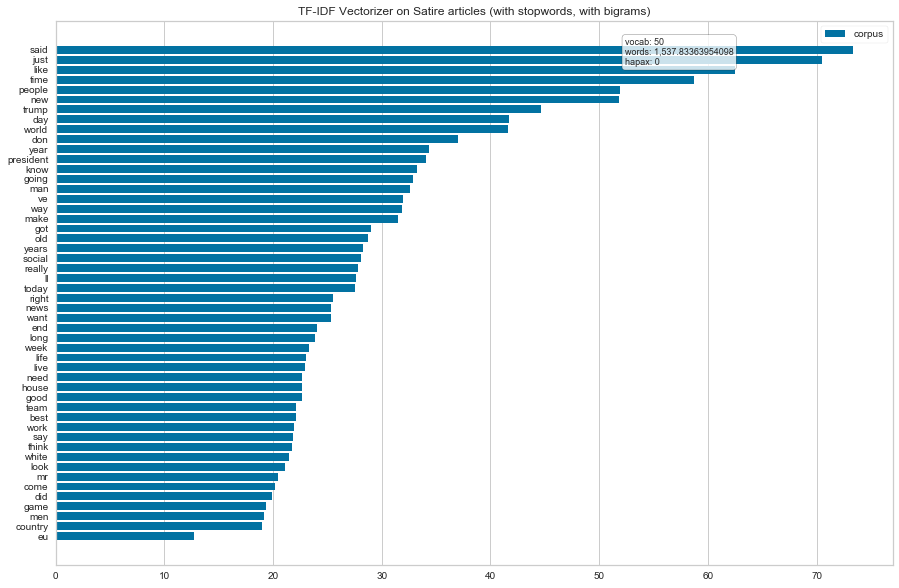

In [119]:
satire_text_tvec_stops_bigrams = tvec_stops_bigrams.fit_transform(satire_class['truncated_text'])
top_50_satire_tvec_stops_bigrams = tvec_stops_bigrams.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire_tvec_stops_bigrams, 
                          title='TF-IDF Vectorizer on Satire articles (with stopwords, with bigrams)')
plot.fit(satire_text_tvec_stops_bigrams)
plot.poof()

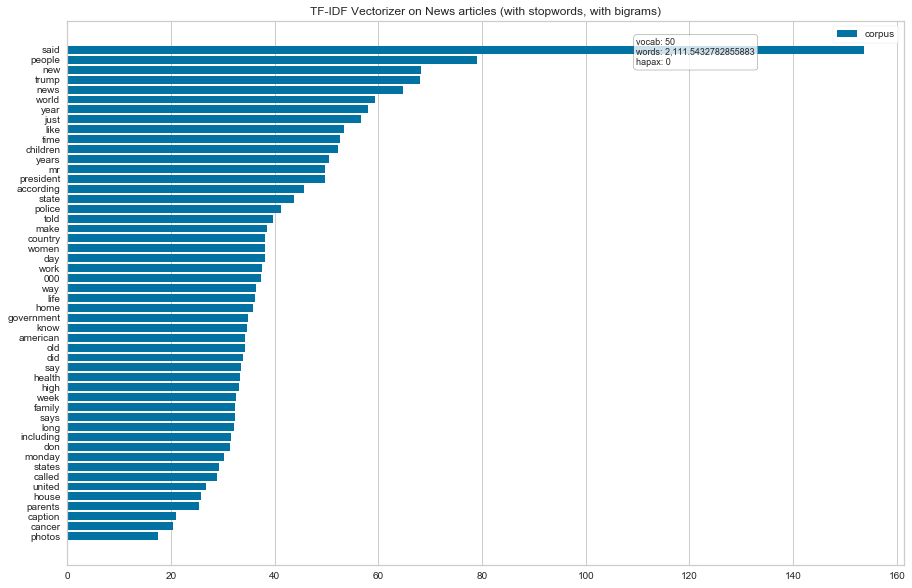

In [120]:
news_text_tvec_stops_bigrams = tvec_stops_bigrams.fit_transform(news_class['truncated_text'])
top_50_news_tvec_stops_bigrams = tvec_stops_bigrams.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news_tvec_stops_bigrams, 
                          title='TF-IDF Vectorizer on News articles (with stopwords, with bigrams)')
plot.fit(news_text_tvec_stops_bigrams)
plot.poof()

In [121]:
# TF-IDF Vectorizer with stopwords, using bigrams (2,2)

tvec_stops_bigrams2 = TfidfVectorizer(stop_words='english', max_features=50, ngram_range=(2,2))

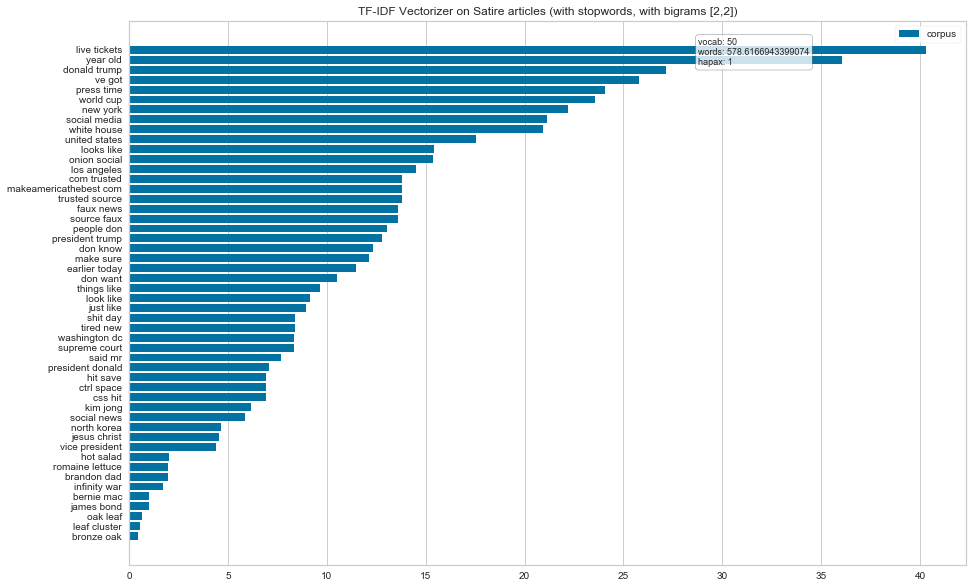

In [122]:
satire_text_tvec_stops_bigrams2 = tvec_stops_bigrams2.fit_transform(satire_class['truncated_text'])
top_50_satire_tvec_stops_bigrams2 = tvec_stops_bigrams2.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_satire_tvec_stops_bigrams2, 
                          title='TF-IDF Vectorizer on Satire articles (with stopwords, with bigrams [2,2])')
plot.fit(satire_text_tvec_stops_bigrams2)
plot.poof()

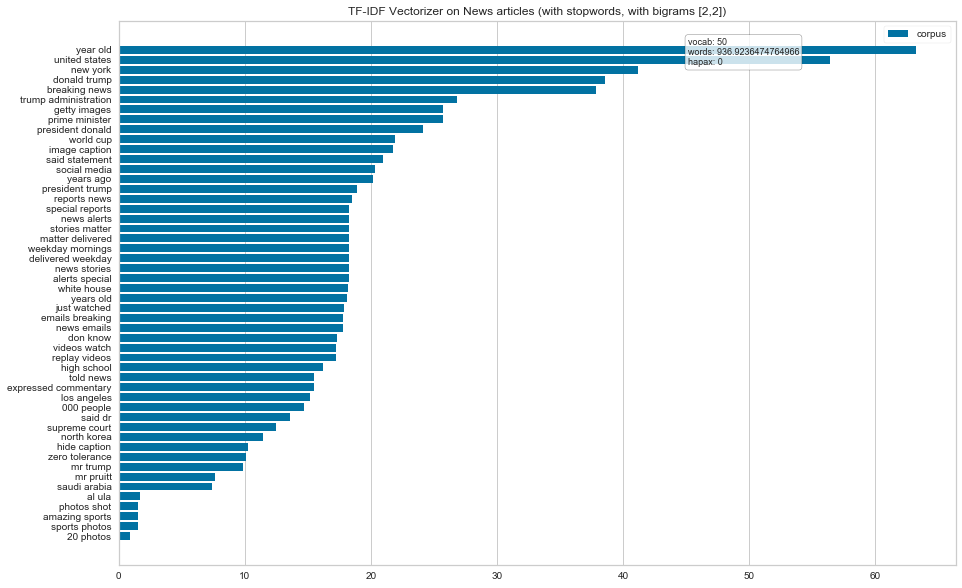

In [123]:
news_text_tvec_stops_bigrams2 = tvec_stops_bigrams2.fit_transform(news_class['truncated_text'])
top_50_news_tvec_stops_bigrams2 = tvec_stops_bigrams2.get_feature_names()

fig = plt.figure(figsize=(15,10))
plot = FreqDistVisualizer(ax = fig.gca(), features = top_50_news_tvec_stops_bigrams2, 
                          title='TF-IDF Vectorizer on News articles (with stopwords, with bigrams [2,2])')
plot.fit(news_text_tvec_stops_bigrams2)
plot.poof()

**Lemmatizing**

In [5]:
lemmatizer = WordNetLemmatizer()

all_articles['lemmatized_text'] = all_articles['truncated_text'].map(lambda x: " ".join([lemmatizer.lemmatize(x) \
                                                                                         for x in x.split()]))

In [6]:
all_articles['lemmatized_text'].iloc[0]

'LA MALBAIE, CANADA ()—Saying that they were “tremendously relieved” that Donald J. Trump is leaving the G-7 summit early, the leader of France and Canada said on Friday that they had been planning not to tell Trump the location of the G-7 after party. Speaking to reporters, Emmanuel Macron and Justin Trudeau said that there had been “total consensus” among non-U.S. participant to withhold information about the time, place, and existence of an after party from Trump. “The plan was, if Trump asked about an after party, we were going to be, like, ‘Ask Angela Merkel,’ ” Macron said. “Angela wa going to totally stonewall him.” Merkel confirmed that she had planned to tell Trump that she “didn’t think anyone wa planning to do anything” after the summit and steadfastly to deny “hearing anything” about an after party. “I would have had no problem lying to him, despite our two country going way back, to D-Day or whenever,” Merkel said, rolling her eyes. Trudeau said that the after party will p

In [ ]:
# Given crude nature of Porter Stemming, will stick with Lemmatizing

# Modeling

In [7]:
# Baseline accuracy

len(all_articles[all_articles['label']==1])/len(all_articles['label'])

0.44369521240728255

**Lemmatized Text - with GridSearch to find best parameters**

In [71]:
X = all_articles['lemmatized_text']
y = all_articles['label']

X_train_lemm, X_test_lemm, y_train_lemm, y_test_lemm = train_test_split(X, y, random_state=42)

X_train_tvec = tvec_stops.fit_transform(X_train_lemm)
X_test_tvec = tvec_stops.transform(X_test_lemm)

In [973]:
# Logistic Regression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_tvec, y_train_lemm)
print(logreg.score(X_train_tvec, y_train_lemm))
print(logreg.score(X_test_tvec, y_test_lemm))

0.7634892086330936
0.7574123989218329


In [975]:
params_logreg = {
    'penalty': ['l1', 'l2'], 
    'C': [1.0, .1, .01, .001]
}
gs_logreg = GridSearchCV(logreg, param_grid=params_logreg, cv=5, scoring='accuracy', verbose=1) 
gs_logreg.fit(X_train_tvec, y_train_lemm)

print(gs_logreg.best_score_)
print(gs_logreg.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.7401079136690647
{'C': 1.0, 'penalty': 'l2'}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [72]:
best_logreg = LogisticRegression(random_state=42, C=1.0, penalty='l2')
best_logreg.fit(X_train_tvec, y_train_lemm)
print(best_logreg.score(X_train_tvec, y_train_lemm))
print(best_logreg.score(X_test_tvec, y_test_lemm))

0.7634892086330936
0.7574123989218329


In [977]:
# Random Forest

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tvec, y_train_lemm)
print(rf.score(X_train_tvec, y_train_lemm))
print(rf.score(X_test_tvec, y_test_lemm))

0.9775179856115108
0.7358490566037735


In [978]:
params_rf = {
    'n_estimators': [27, 30, 31, 32], 
    'criterion': ['gini', 'entropy'],
    'max_features': [7, 8, 9],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'warm_start': [True, False]
}
gs_rf = GridSearchCV(rf, param_grid=params_rf, cv=5, scoring='accuracy', verbose=1) 
gs_rf.fit(X_train_tvec, y_train_lemm)

print(gs_rf.best_score_)
print(gs_rf.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
0.7508992805755396
{'criterion': 'entropy', 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 31, 'warm_start': True}


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  1.8min finished


In [73]:
best_rf = RandomForestClassifier(random_state=42, criterion='entropy', max_features=8, 
                                 min_samples_leaf=3, min_samples_split=2, n_estimators=31, warm_start=True)
best_rf.fit(X_train_tvec, y_train_lemm)
print(best_rf.score(X_train_tvec, y_train_lemm))
print(best_rf.score(X_test_tvec, y_test_lemm))

0.9577338129496403
0.7520215633423181


In [980]:
# Support Vector Machine

clf = svm.SVC(kernel='linear', random_state=42)
clf.fit(X_train_tvec, y_train_lemm)
print(clflin.score(X_train_tvec, y_train_lemm))
print(clflin.score(X_test_tvec, y_test_lemm))

0.6007194244604317
0.6388140161725068


In [981]:
clf2 = svm.SVC(C=1, random_state=42)

params_svm = {
    'C': [1.0, 0.1, 0.01, 0.001], 
    'kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
    'degree': [2, 3, 4, 5],
    'gamma': [1.0, 0.1, 0.01, 0.001, 'auto']
}
gs_svm = GridSearchCV(clf2, param_grid=params_svm, cv=5, scoring='accuracy', verbose=1) 
gs_svm.fit(X_train_tvec, y_train_lemm)

print(gs_svm.best_score_)
print(gs_svm.best_params_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
0.7428057553956835
{'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:  3.7min finished


In [74]:
best_svm=svm.SVC(random_state=42, C=1.0, kernel='rbf', degree=2, gamma=1.0)
best_svm.fit(X_train_tvec, y_train_lemm)
print(best_svm.score(X_train_tvec, y_train_lemm))
print(best_svm.score(X_test_tvec, y_test_lemm))

0.8615107913669064
0.7654986522911051


In [984]:
# Multinomial Naïve Bayes

mnb = MultinomialNB()
mnb.fit(X_train_tvec, y_train_lemm)
print(mnb.score(X_train_tvec, y_train_lemm))
print(mnb.score(X_test_tvec, y_test_lemm))

0.7068345323741008
0.7439353099730458


In [985]:
params_mnb = {
    'alpha': [1.0, 0.1, 0],
    'fit_prior': [True, False]
}
gs_mnb = GridSearchCV(mnb, param_grid=params_mnb, cv=5, scoring='accuracy', verbose=1) 
gs_mnb.fit(X_train_tvec, y_train_lemm)

print(gs_mnb.best_score_)
print(gs_mnb.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.7014388489208633
{'alpha': 0.1, 'fit_prior': True}


/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/nai

In [75]:
best_mnb = MultinomialNB(alpha=0.1, fit_prior=True)
best_mnb.fit(X_train_tvec, y_train_lemm)
print(best_mnb.score(X_train_tvec, y_train_lemm))
print(best_mnb.score(X_test_tvec, y_test_lemm))

0.7095323741007195
0.7439353099730458


**Neural Network - LSTM**

In [8]:
max_sequence_length = 650 # Max number of words/article
max_num_words = 10000 # Max number of words in vocabulary

tokenizer = Tokenizer(num_words=max_num_words)

# Learn vocab & ID most common words (in lieu of TF-IDF)

tokenizer.fit_on_texts(all_articles['lemmatized_text'].values) 

# Turn vocab to sequences of word indices

sequences = tokenizer.texts_to_sequences(all_articles['lemmatized_text'].values)
word_index = tokenizer.word_index

# Prepending zeros to all sequences for padding

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length) # Feature in model

print(f'Found {len(word_index)} unique tokens/words')
print(f'The maximum word index is {padded_sequences.max()}')

Found 30171 unique tokens/words
The maximum word index is 9999


In [9]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, all_articles['label'], 
                                                    test_size=0.33, random_state=42)

X_train.shape, y_train.shape

((993, 650), (993,))

In [21]:
# Loading glove weights for LSTM

glove_dir = './Assets/glove.6B'

embeddings_index = {}

with open(os.path.join(glove_dir, 'glove.6B.200d.txt')) as f: # 200d refers to number of dimensions
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors')

embedding_dim = 200

embedding_matrix = np.zeros((max_num_words, embedding_dim))
for word, index in word_index.items():
    if index < max_num_words:
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Found 400000 word vectors


In [24]:
# Establishing random state for neural network

seed(42)
set_random_seed(2)

# Instantiating Neural Network

model = Sequential()
model.add(Embedding(max_num_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(20))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix]) # pre-trained weights
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Incorporating Early Stopping to avoid excessive loss

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
callbacks_list = [early_stop]

history2 = model.fit(X_train, y_train, 
                     epochs=75, 
                     batch_size=max_sequence_length, 
                     validation_data=(X_test, y_test),
                     callbacks=callbacks_list)

Train on 993 samples, validate on 490 samples
Epoch 1/75
993/993 [==============================] - 8s 8ms/step - loss: 0.6889 - acc: 0.5498 - val_loss: 0.6779 - val_acc: 0.5714
Epoch 2/75
993/993 [==============================] - 7s 7ms/step - loss: 0.6624 - acc: 0.5921 - val_loss: 0.6628 - val_acc: 0.5776
Epoch 3/75
993/993 [==============================] - 7s 7ms/step - loss: 0.6400 - acc: 0.6052 - val_loss: 0.6445 - val_acc: 0.6449
Epoch 4/75
993/993 [==============================] - 7s 7ms/step - loss: 0.6163 - acc: 0.6808 - val_loss: 0.6255 - val_acc: 0.6796
Epoch 5/75
993/993 [==============================] - 7s 7ms/step - loss: 0.5927 - acc: 0.7331 - val_loss: 0.6080 - val_acc: 0.6980
Epoch 6/75
993/993 [==============================] - 8s 8ms/step - loss: 0.5695 - acc: 0.7664 - val_loss: 0.5904 - val_acc: 0.7184
Epoch 7/75
993/993 [==============================] - 7s 7ms/step - loss: 0.5461 - acc: 0.7815 - val_loss: 0.5719 - val_acc: 0.7347
Epoch 8/75
993/993 [==========

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 650, 200)          2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                17680     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,017,701
Trainable params: 2,017,701
Non-trainable params: 0
_________________________________________________________________


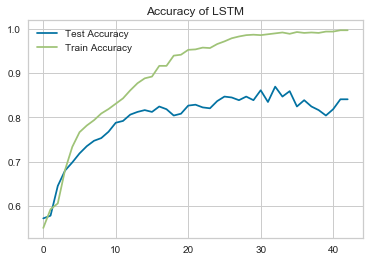

In [124]:
# Plotting accuracy of model

plt.plot(history2.history['val_acc'], label='Test Accuracy')
plt.plot(history2.history['acc'], label='Train Accuracy')
plt.title('Accuracy of LSTM')
plt.legend();

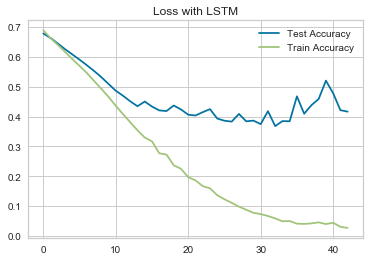

In [125]:
# Plotting loss of model

plt.plot(history2.history['val_loss'], label='Test Accuracy')
plt.plot(history2.history['loss'], label='Train Accuracy')
plt.title('Loss with LSTM')
plt.legend();

**Predictions**

In [27]:
# Since LSTM worked best, will use this for getting predictions

y_hat = model.predict(X_test)

In [28]:
# Because softmax function wasn't working, will convert sigmoid predict_probas into 0/1

y_hat[y_hat >= 0.5] = 1
y_hat[y_hat < 0.5] = 0

In [29]:
print(y_hat[0:5])

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]]


# Evaluations & Visualizations

**ROC**

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat)
roc_auc = metrics.auc(fpr, tpr)

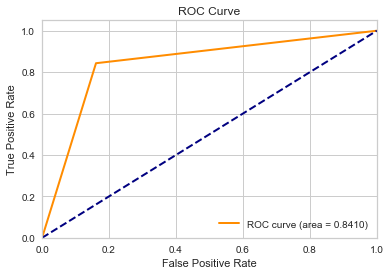

In [126]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Evaluation Metrics**

In [91]:
f1 = metrics.f1_score(y_test, y_hat)
precision = metrics.precision_score(y_test, y_hat)
recall = metrics.recall_score(y_test, y_hat)
brier = brier_score_loss(y_test, y_hat)
print(f1, precision, recall, brier)

0.8281938325991188 0.8138528138528138 0.8430493273542601 0.15918367346938775


In [93]:
model_types = {best_logreg: 'Logistic Regression', best_rf: 'Random Forest', 
               best_svm: 'SVM', best_mnb: 'Multinomial Bayes'}

for i, v, in model_types.items():
    y_hat_i = i.predict(X_test_tvec)
    
    f1 = metrics.f1_score(y_test_lemm, y_hat_i)
    precision = metrics.precision_score(y_test_lemm, y_hat_i)
    recall = metrics.recall_score(y_test_lemm, y_hat_i)
    brier = brier_score_loss(y_test_lemm, y_hat_i)
    
    print('%s: ' %v)
    print('F1: ', f1)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print("Brier's score: ", brier)
    print()

Logistic Regression: 
F1:  0.6938775510204082
Precision:  0.7338129496402878
Recall:  0.6580645161290323
Brier's score:  0.24258760107816713

Random Forest: 
F1:  0.6933333333333334
Precision:  0.7172413793103448
Recall:  0.6709677419354839
Brier's score:  0.24797843665768193

SVM: 
F1:  0.7030716723549488
Precision:  0.7463768115942029
Recall:  0.6645161290322581
Brier's score:  0.23450134770889489

Multinomial Bayes: 
F1:  0.6387832699619773
Precision:  0.7777777777777778
Recall:  0.5419354838709678
Brier's score:  0.2560646900269542



**Confusion Matrices for Models**

In [1010]:
# Adopted from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Greens):
    
    plt.imshow(cm, cmap=cmap)
    plt.grid(False)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

[[240  27]
 [ 58 165]]


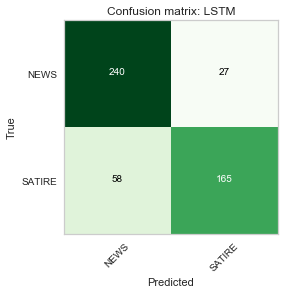

In [1011]:
cnf_matrix = confusion_matrix(y_test, y_hat)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NEWS', 'SATIRE'],
                      title='Confusion matrix: LSTM')
print(cnf_matrix)

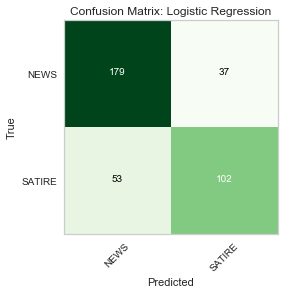

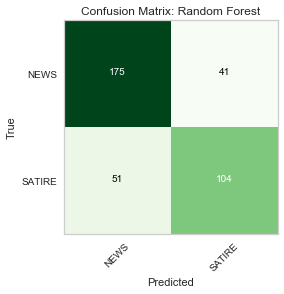

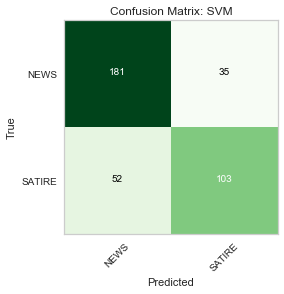

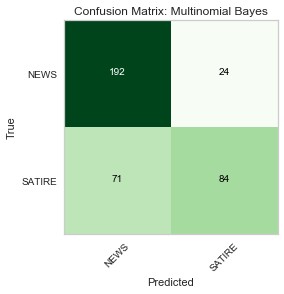

In [1012]:
for i,v in model_types.items():
    plt.figure()
    plot_confusion_matrix(confusion_matrix(y_test_lemm, i.predict(X_test_tvec)), 
                          classes=['NEWS', 'SATIRE'], 
                          title='Confusion Matrix: %s' % v)
    plt.show()

**Word Clouds**

In [ ]:
# Initially, when first running these clouds, identified boilerplate language that needed to be removed 
# from articles to avoid overfitting

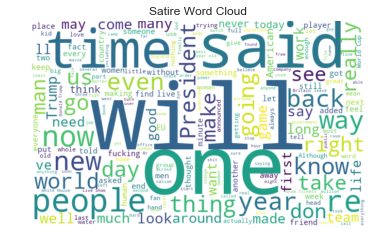

In [127]:
# Satire
wordcloud = WordCloud(width=650,
                      height=400,
                      max_font_size=None,
                      background_color='white').generate(' '.join(satire_class['final_clean_text']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Satire Word Cloud')
plt.axis("off")
plt.show()

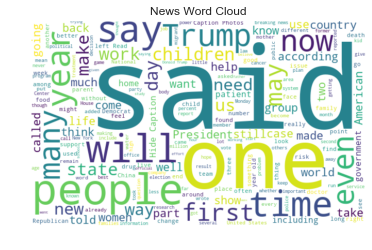

In [128]:
# News
wordcloud = WordCloud(width=650,
                      height=400,
                      max_font_size=None,
                      background_color='white'
                     ).generate(' '.join(news_class['final_clean_text']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('News Word Cloud')
plt.axis("off")
plt.show()

In [57]:
# Taken from: 
# http://luisvalesilva.com/datasimple/word_clouds.html

from PIL import Image
from wordcloud import WordCloud, STOPWORDS

def make_word_cloud(input_text, mask, output_file_name, stopwords=None, extra_stopwords=None,
                    bckgrd_color = "white", max_words=100):

    text = open(input_text).read()
    mask = np.array(Image.open(mask))
    stopwords = set(stopwords)
    if extra_stopwords is not None:
        [stopwords.add(word) for word in extra_stopwords]
    wc = WordCloud(background_color=bckgrd_color, max_words=max_words,
                   mask=mask, stopwords=stopwords)

    wc.generate(text)
    wc.to_file(output_file_name)

In [58]:
np.savetxt(r'./Assets/satire_text.txt', satire_class['final_clean_text'], fmt='%s')

In [63]:
make_word_cloud(input_text="./Assets/satire_text.txt", mask="./Assets/OnionLogo_reversed.jpg", 
                extra_stopwords=['re', 'll'],  output_file_name="./Assets/Onion_with_text.png", stopwords=STOPWORDS)

**Sentiment Analysis** - Just for Fun

In [961]:
all_articles['polarity'] = all_articles['truncated_text'].map(lambda x: TextBlob(x).sentiment.polarity)
all_articles['subjectivity'] = all_articles['truncated_text'].map(lambda x: TextBlob(x).sentiment.subjectivity)

In [967]:
all_articles['polarity'].describe()

count    1483.000000
mean        0.084511
std         0.139082
min        -0.714286
25%         0.009416
50%         0.072689
75%         0.142372
max         1.000000
Name: polarity, dtype: float64